In [120]:
import cv2
import h5py
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.ndimage import binary_fill_holes
from scipy.special import ellipe
from PIL import Image

pd.set_option('display.max_columns', 100)

In [135]:
PATH_TO_HOVERNET_OUT = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/hovernet_out"
PATH_TO_SAMPLE_PATCH = os.path.join(PATH_TO_HOVERNET_OUT, "tma5-E0683B_v1-39")
PATH_TO_SAMPLE_PATCH_SEG_MAP = os.path.join(PATH_TO_SAMPLE_PATCH, "instances.npy")
PATH_TO_SAMPLE_PATCH_IMAGE = os.path.join(PATH_TO_SAMPLE_PATCH, "overlay.png")
PATH_TO_SAMPLE_PATCH_INSTANCE_DICT = os.path.join(PATH_TO_SAMPLE_PATCH, "nuclei_dict.json")

PATH_TO_OUTPUT_CELLS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells"
PATH_TO_CELLS_HDF5 = os.path.join(PATH_TO_OUTPUT_CELLS, "cells.hdf5")
PATH_TO_AGG_GEO_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "features")

## Inspect Data in Hovernet Output Directory

In [41]:
num_patches = len(os.listdir(PATH_TO_HOVERNET_OUT))
print(f"Number of patches extracted by HoVer-Net: {num_patches}")

Number of patches extracted by HoVer-Net: 138386


(224, 224)


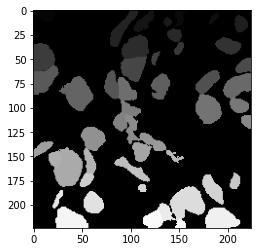

In [16]:
seg_map = np.load(PATH_TO_SAMPLE_PATCH_SEG_MAP)
image = Image.open(PATH_TO_SAMPLE_PATCH_IMAGE)
print(seg_map.shape)
plt.imshow(seg_map, cmap="gray")

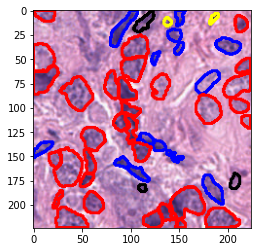

In [17]:
plt.imshow(image)

In [18]:
cell_nums = set(seg_map.flatten())
print(cell_nums)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}


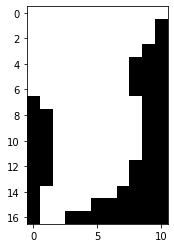

In [19]:
def crop_im(im):
    arg_ones = np.argwhere(im) # shape: (pixels_of_ones, 2)
    row_min, col_min = np.amin(arg_ones, axis=0)
    row_max, col_max = np.amax(arg_ones, axis=0)
    
    return im[row_min:row_max+1, col_min:col_max+1]

cell_id = 2
cell_mask = (seg_map == cell_id)
im_cell = crop_im(cell_mask)
plt.imshow(im_cell, cmap='gray')

In [106]:
with open(PATH_TO_SAMPLE_PATCH_INSTANCE_DICT) as json_file:
    data = json.load(json_file)
    cell_type = data['2']['type']
    contours = data['2']['contour']
print(f"Cell type: {cell_type}")
print(contours)

Cell type: 3
[[146, 0], [146, 6], [148, 8], [148, 13], [147, 14], [147, 16], [148, 16], [149, 15], [150, 15], [151, 14], [152, 14], [153, 13], [153, 12], [154, 11], [154, 7], [153, 6], [153, 4], [155, 2], [155, 1], [156, 0]]


## Load and visualize nucleus segmentation mask

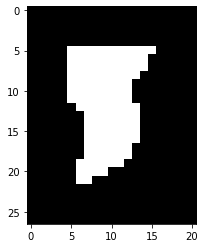

In [26]:
img = np.pad(im_cell, 5) 
img = binary_fill_holes(img) #fill holes that sometimes appear inside the segmentation mask

mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255
plt.imshow(img, cmap='gray')
plt.show()

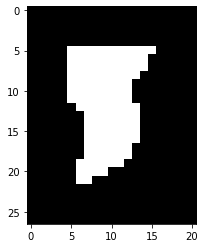

In [29]:
ret, thresh = cv2.threshold(img,127,255,0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

plt.imshow(thresh, cmap='gray')
plt.show()

## Fit rectangle

Rectangle center: (10.0, 13.0)
Rectangle width: 16.000000, height: 10.000000
Rectangle rotation angle: 90.0


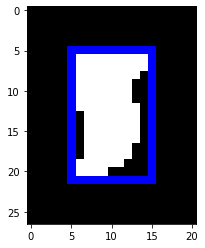

In [32]:
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])

## Fit ellipse

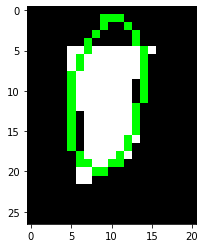

In [33]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

ellipse = cv2.fitEllipseDirect(cnt)  #(x, y), (major, minor), angle                                                            
ell = cv2.ellipse(rgb_img,ellipse,(0,255,0),1)
(ellpCtr_x, ellpCtr_y), (shortAxis, longAxis), angle = ellipse
plt.imshow(rgb_img)

In [38]:
# perimeter and area of ellipse                                                                                                            
a = longAxis / 2
b = shortAxis / 2
e = np.sqrt(1 - b**2 / a**2)  # eccentricity                                                                                       
perimt = 4 * a * ellipe(e*e)
area = np.pi * a * b

In [39]:
print("Ellipse centroid:", (ellpCtr_x, ellpCtr_y))
print("Major axis (longAxis) length: %.6f" % longAxis)
print("Minor axis (shortAxis) length: %.6f" % shortAxis)
print("Ellipse parimeter: %.6f" % perimt)
print("Ellipse area: %.6f" % area)

Ellipse centroid: (9.303385734558105, 10.593705177307129)
Major axis (longAxis) length: 19.193127
Minor axis (shortAxis) length: 8.881088
Ellipse parimeter: 45.599310
Ellipse area: 133.875713


## Convex hull area

In [40]:
hull = cv2.convexHull(cnt)
hull_area = cv2.contourArea(hull)
print("Convex hull area: %.6f" % hull_area)

Convex hull area: 123.500000


## Get Number of Cells Extracted

In [76]:
cell_hdf5_files = glob.glob(os.path.join(PATH_TO_OUTPUT_CELLS, "tma*_cells.hdf5"))
cell_shapes_files = glob.glob(os.path.join(PATH_TO_OUTPUT_CELLS, "tma*_cell_shapes.csv"))

In [77]:
def get_tma_id_from_filename(filename):
    return filename.split("/")[-1].split("_")[0]

cell_shapes_files

['/sailhome/vivek96/lymphoma/processed/cells/tma1_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma8_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma3_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma4_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma6b_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma5_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma2_cells.hdf5',
 '/sailhome/vivek96/lymphoma/processed/cells/tma6a_cells.hdf5']

In [79]:
cell_hdf5_map = {get_tma_id_from_filename(filename) : h5py.File(filename, "r") for filename in cell_hdf5_files}
cell_shapes_df_map = {get_tma_id_from_filename(filename) : pd.read_csv(filename) for filename in cell_shapes_files}

In [80]:
print(len(cell_shapes_df_map.keys()))

8


In [81]:
tma1_df = cell_shapes_df_map['tma1']
tma1_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,hull_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,cell_type
0,0,tma1,E0002B_v1,0,1,26.565050,15.060187,18.662271,53.122317,220.741891,231.0,7.800000,9.900000,15.652474,17.888544,7.903851,10.144740,1
1,1,tma1,E0002B_v1,0,2,12.528809,15.807603,16.977793,51.515582,210.783750,217.0,8.905882,7.423531,17.137506,15.402064,8.768550,8.256520,2
2,2,tma1,E0002B_v1,0,3,45.000000,10.140018,11.546165,34.100389,91.953090,89.0,4.750000,5.250000,9.899494,10.606602,4.993966,5.515516,2
3,3,tma1,E0002B_v1,0,4,39.805569,13.411483,14.622210,44.055757,154.020909,147.5,5.409836,9.508198,13.315837,14.084057,5.501787,8.762449,2
4,4,tma1,E0002B_v1,0,5,38.659809,21.966085,22.973110,70.599185,396.334926,395.0,10.207318,11.865853,21.395805,21.708153,10.932357,12.005103,1


In [82]:
num_cells = sum([cell_shape_df.shape[0] for (tma_id, cell_shape_df) in cell_shapes_df_list.items()])
print(f"Total number of extracted cells: {num_cells}")

Total number of extracted cells: 7997643


## Inspect an individual cell in the cells HDF5 file

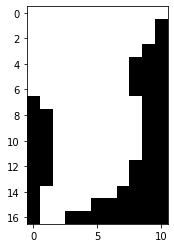

In [107]:
tma_id = "tma5"
patient_id = "E0683B_v1"
patch_id = "39"
cell_id = "2"

tma5_file = cell_hdf5_map[tma_id]
cell_data = tma5_file[tma_id][patient_id][patch_id][cell_id][cell_id]
cell_npy = np.zeros(cell_data.shape)
cell_data.read_direct(cell_npy)
plt.imshow(cell_npy, cmap='gray')

In [108]:
img = binary_fill_holes(cell_npy)
mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

Rectangle center: (5.0, 8.0)
Rectangle width: 16.000000, height: 10.000000
Rectangle rotation angle: 90.0


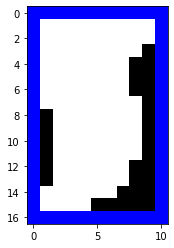

In [109]:
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])

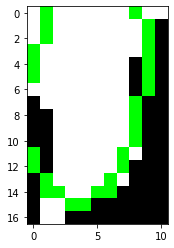

In [110]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

ellipse = cv2.fitEllipseDirect(cnt)  #(x, y), (major, minor), angle                                                            
ell = cv2.ellipse(rgb_img,ellipse,(0,255,0),1)
(ellpCtr_x, ellpCtr_y), (shortAxis, longAxis), angle = ellipse
plt.imshow(rgb_img)

In [111]:
# perimeter and area of ellipse                                                                                                            
a = longAxis / 2
b = shortAxis / 2
e = np.sqrt(1 - b**2 / a**2)  # eccentricity                                                                                       
perimt = 4 * a * ellipe(e*e)
area = np.pi * a * b

In [112]:
print("Ellipse centroid:", (ellpCtr_x, ellpCtr_y))
print("Major axis (longAxis) length: %.6f" % longAxis)
print("Minor axis (shortAxis) length: %.6f" % shortAxis)
print("Ellipse parimeter: %.6f" % perimt)
print("Ellipse area: %.6f" % area)

Ellipse centroid: (4.3033857345581055, 5.593704700469971)
Major axis (longAxis) length: 19.193127
Minor axis (shortAxis) length: 8.881088
Ellipse parimeter: 45.599310
Ellipse area: 133.875713


## Get Geometric Features for Cell

In [130]:
tma5_df = cell_shapes_df_map[tma_id]
tma5_df.head()

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,hull_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,cell_type
0,0,tma5,E0486B_v1,0,1,90.000000,13.798190,26.200121,64.348569,283.932628,290.0,12.000000,7.500000,15.000000,24.000000,11.837361,7.053302,1
1,1,tma5,E0486B_v1,0,10,90.000000,14.680865,18.534990,52.351109,213.714455,224.5,10.000000,7.000000,14.000000,20.000000,10.760929,5.780444,2
2,2,tma5,E0486B_v1,0,11,16.699244,10.586707,17.642282,45.037256,146.691703,158.5,5.793578,10.188074,11.206569,18.486048,5.550933,10.026292,2
3,3,tma5,E0486B_v1,0,12,39.805569,5.002738,9.556414,23.432272,37.548495,34.5,4.778688,4.565574,5.505586,9.858840,4.759400,3.699540,0
4,4,tma5,E0486B_v1,0,13,90.000000,16.570950,17.068466,52.843560,222.142560,222.0,8.500000,8.000000,16.000000,17.000000,8.700495,8.646334,2


In [104]:
tma5_df[(tma5_df["tma_id"] == tma_id) & 
        (tma5_df["patient_id"] == patient_id) & 
        (tma5_df["patch_id"] == int(patch_id)) & 
        (tma5_df["cell_id"] == int(cell_id))]

,Unnamed: 0,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,ellipse_area,hull_area,rect_center_x,rect_center_y,rect_width,rect_height,ellipse_centroid_x,ellipse_centroid_y,cell_type
1607386,1607386,tma5,E0683B_v1,39,2,90.0,8.881088,19.193127,45.59931,133.875713,123.5,5.0,8.0,16.0,10.0,4.303386,5.593705,3


## Aggregate Features Across All Patches + Cells for Each Patient

In [176]:
NEW_AGG_COLS = ["rotate_angle_mean", "rotate_angle_std",
                "short_axis_mean", "short_axis_std",
                "long_axis_mean", "long_axis_std",
                "ellipse_perim_mean", "ellipse_perim_std",
                "ellipse_area_mean", "ellipse_area_std",
                "hull_area_mean", "hull_area_std",
                "rect_center_x_mean", "rect_center_x_std",
                "rect_center_y_mean", "rect_center_y_std",
                "rect_width_mean", "rect_width_std",
                "rect_height_mean", "rect_height_std",
                "ellipse_centroid_x_mean", "ellipse_centroid_x_std",
                "ellipse_centroid_y_mean", "ellipse_centroid_y_std"]

In [177]:
patient_set = set(tma5_df['patient_id'])
print(f"Number of patients: {len(patient_set)}")

Number of patients: 329


In [178]:
tma5_df_copy = tma5_df.copy()
tma5_df_copy = tma5_df_copy.drop(["Unnamed: 0", "patch_id", "cell_id", "cell_type"], axis=1)
tma5_average_df = tma5_df_copy.groupby('patient_id').agg([np.mean, np.std])
display(tma5_average_df.head())

rotate_angle            short_axis            long_axis            \
                   mean        std       mean       std       mean       std   
patient_id                                                                     
E0486B_v1     64.143119  29.402088  14.690523  3.718745  20.579367  5.550408   
E0486B_v2     62.965641  29.264646  14.448850  3.729894  20.466266  5.548653   
E0487B_v1     65.351694  29.127162  13.527377  3.307540  20.458567  5.973727   
E0488C_v1     64.641170  28.275409  15.389257  3.585052  21.078112  4.813439   
E0488C_v2     66.218605  28.269159  15.534112  3.599096  20.973176  4.931117   

           ellipse_perim            ellipse_area               hull_area  \
                    mean        std         mean         std        mean   
patient_id                                                                 
E0486B_v1      55.910779  13.725210   248.926887  122.788330  239.723685   
E0486B_v2      55.378499  13.721192   243.701878  123.837189  235.467518   
E0487B_v1      54.117099  13.534627   226.256054  108.027805  220.238964   
E0488C_v1      57.753152  12.156467   263.610893  103.550261  251.259312   
E0488C_v2      57.797530  12.271201   264.547564  105.422089  252.141722   

                       rect_center_x           rect_center_y            \
                   std          mean       std          mean       std   
patient_id                                                               
E0486B_v1   122.645295      8.418966  2.616751      8.982349  2.827862   
E0486B_v2   123.024918      8.772436  2.802706      8.535675  2.678563   
E0487B_v1   108.791130      9.220730  3.120209      7.626870  2.264349   
E0488C_v1   106.964762      8.966770  2.588094      8.925552  2.513560   
E0488C_v2   108.975550      8.849421  2.523697      9.010201  2.625004   

           rect_width           rect_height           ellipse_centroid_x  \
                 mean       std        mean       std               mean   
patient_id                                                                 
E0486B_v1   17.222149  5.682800   17.021591  5.430682           8.427546   
E0486B_v2   17.118253  5.688706   16.874992  5.398449           8.779149   
E0487B_v1   15.820081  5.606343   17.360922  6.027524           9.214153   
E0488C_v1   17.513140  5.149024   17.665457  5.156801           8.982342   
E0488C_v2   17.854014  5.428073   17.328887  4.953652           8.866411   

                     ellipse_centroid_y            
                 std               mean       std  
patient_id                                         
E0486B_v1   2.789665           8.974837  3.049831  
E0486B_v2   2.985195           8.545147  2.853083  
E0487B_v1   3.281233           7.622259  2.355809  
E0488C_v1   2.794451           8.923799  2.714706  
E0488C_v2   2.723622           9.018235  2.856923

In [179]:
tma5_average_df.columns = tma5_average_df.columns.droplevel(0)
tma5_average_df.columns = NEW_AGG_COLS
tma5_average_df["tma_id"] = "tma5"
display(tma5_average_df.head())

,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,hull_area_mean,hull_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,tma_id
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,
E0486B_v1,64.143119,29.402088,14.690523,3.718745,20.579367,5.550408,55.910779,13.725210,248.926887,122.788330,239.723685,122.645295,8.418966,2.616751,8.982349,2.827862,17.222149,5.682800,17.021591,5.430682,8.427546,2.789665,8.974837,3.049831,tma5
E0486B_v2,62.965641,29.264646,14.448850,3.729894,20.466266,5.548653,55.378499,13.721192,243.701878,123.837189,235.467518,123.024918,8.772436,2.802706,8.535675,2.678563,17.118253,5.688706,16.874992,5.398449,8.779149,2.985195,8.545147,2.853083,tma5
E0487B_v1,65.351694,29.127162,13.527377,3.307540,20.458567,5.973727,54.117099,13.534627,226.256054,108.027805,220.238964,108.791130,9.220730,3.120209,7.626870,2.264349,15.820081,5.606343,17.360922,6.027524,9.214153,3.281233,7.622259,2.355809,tma5
E0488C_v1,64.641170,28.275409,15.389257,3.585052,21.078112,4.813439,57.753152,12.156467,263.610893,103.550261,251.259312,106.964762,8.966770,2.588094,8.925552,2.513560,17.513140,5.149024,17.665457,5.156801,8.982342,2.794451,8.923799,2.714706,tma5
E0488C_v2,66.218605,28.269159,15.534112,3.599096,20.973176,4.931117,57.797530,12.271201,264.547564,105.422089,252.141722,108.975550,8.849421,2.523697,9.010201,2.625004,17.854014,5.428073,17.328887,4.953652,8.866411,2.723622,9.018235,2.856923,tma5


In [181]:
def aggregate_geo_features(cell_shapes_df_map):
    for tma_id in cell_shapes_df_map:
        print(tma_id)
        tma_df = cell_shapes_df_map[tma_id]
        patient_set = set(tma_df['patient_id'])
        print(f"Number of patients: {len(patient_set)}")
        tma_df_copy = tma_df.copy()
        tma_df_copy = tma_df_copy.drop(["Unnamed: 0", "patch_id", "cell_id", "cell_type"], axis=1)
        tma_average_df = tma_df_copy.groupby('patient_id').agg([np.mean, np.std])
        tma_average_df.columns = tma_average_df.columns.droplevel(0)
        tma_average_df.columns = NEW_AGG_COLS
        tma_average_df["tma_id"] = tma_id
        print(f"Number of rows in aggregated df: {tma_average_df.shape[0]}")
        tma_average_df.to_csv(os.path.join(PATH_TO_AGG_GEO_FEATURES, f"{tma_id}_geo_features.csv"))
    print("Done!")

aggregate_geo_features(cell_shapes_df_map)

tma8
Number of patients: 48
Number of rows in aggregated df: 48
tma4
Number of patients: 164
Number of rows in aggregated df: 164
tma5
Number of patients: 329
Number of rows in aggregated df: 329
tma6b
Number of patients: 172
Number of rows in aggregated df: 172
tma3
Number of patients: 126
Number of rows in aggregated df: 126
tma2
Number of patients: 251
Number of rows in aggregated df: 251
tma1
Number of patients: 155
Number of rows in aggregated df: 155
tma6a
Number of patients: 205
Number of rows in aggregated df: 205
Done!


In [182]:
tma5_geo_features_df = pd.read_csv(os.path.join(PATH_TO_AGG_GEO_FEATURES, f"{tma_id}_geo_features.csv"))
tma5_geo_features_df.head()

,patient_id,rotate_angle_mean,rotate_angle_std,short_axis_mean,short_axis_std,long_axis_mean,long_axis_std,ellipse_perim_mean,ellipse_perim_std,ellipse_area_mean,ellipse_area_std,hull_area_mean,hull_area_std,rect_center_x_mean,rect_center_x_std,rect_center_y_mean,rect_center_y_std,rect_width_mean,rect_width_std,rect_height_mean,rect_height_std,ellipse_centroid_x_mean,ellipse_centroid_x_std,ellipse_centroid_y_mean,ellipse_centroid_y_std,tma_id
0,E0486B_v1,64.143119,29.402088,14.690523,3.718745,20.579367,5.550408,55.910779,13.725210,248.926887,122.788330,239.723685,122.645295,8.418966,2.616751,8.982349,2.827862,17.222149,5.682800,17.021591,5.430682,8.427546,2.789665,8.974837,3.049831,tma5
1,E0486B_v2,62.965641,29.264646,14.448850,3.729894,20.466266,5.548653,55.378499,13.721192,243.701878,123.837189,235.467518,123.024918,8.772436,2.802706,8.535675,2.678563,17.118253,5.688706,16.874992,5.398449,8.779149,2.985195,8.545147,2.853083,tma5
2,E0487B_v1,65.351694,29.127162,13.527377,3.307540,20.458567,5.973727,54.117099,13.534627,226.256054,108.027805,220.238964,108.791130,9.220730,3.120209,7.626870,2.264349,15.820081,5.606343,17.360922,6.027524,9.214153,3.281233,7.622259,2.355809,tma5
3,E0488C_v1,64.641170,28.275409,15.389257,3.585052,21.078112,4.813439,57.753152,12.156467,263.610893,103.550261,251.259312,106.964762,8.966770,2.588094,8.925552,2.513560,17.513140,5.149024,17.665457,5.156801,8.982342,2.794451,8.923799,2.714706,tma5
4,E0488C_v2,66.218605,28.269159,15.534112,3.599096,20.973176,4.931117,57.797530,12.271201,264.547564,105.422089,252.141722,108.975550,8.849421,2.523697,9.010201,2.625004,17.854014,5.428073,17.328887,4.953652,8.866411,2.723622,9.018235,2.856923,tma5
